In [38]:
google_project_path = '/content/drive/MyDrive/ML Projects/'
local_project_path = '/Users/andrewgoh/Desktop/ML_Projects/'

current_path = local_project_path

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

from scipy.optimize import minimize 
from sklearn.metrics import mean_squared_error
from scipy.special import softmax

In [4]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
import tensorflow_datasets as tfds
from tensorflow import keras 

## MNIST Dataset

In [8]:
dataset = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')

training_images = dataset[0][0]
training_labels = dataset[0][1]
testing_images = dataset[1][0]
testing_labels = dataset[1][1]

11490434/11490434 [==============================] - 0s 0us/step


shape of training imgs: (60000, 28, 28)
shape of testing imgs: (10000, 28, 28)
shape of training labels: (60000,)
shape of testing labels: (10000,)


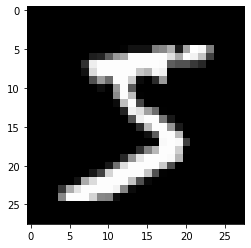

In [9]:
#show data

plt.imshow(training_images[0], cmap = 'gray')
training_labels[0]

print('shape of training imgs:', np.shape(training_images))
print('shape of testing imgs:', np.shape(testing_images))
print('shape of training labels:', np.shape(training_labels))
print('shape of testing labels:', np.shape(testing_labels))

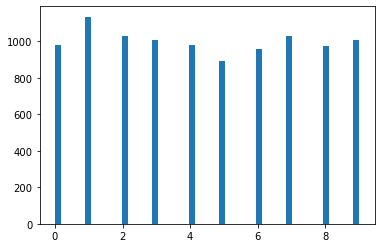

In [10]:
#label distributions 
plt.hist(testing_labels, bins = 50)
plt.show()

## Crude Least Squares Regression (Numpy)

shape: (784,)


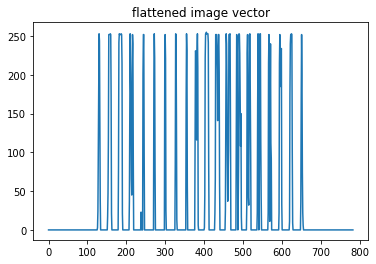

In [11]:
#flatten training data and normalize

a = training_images[555].flatten()
print('shape:', np.shape(a))
plt.plot(a)
plt.title('flattened image vector')

training_images_f = []
for img in training_images:
  training_images_f.append(img.flatten()/255)

# same with test data

testing_images_f = []
for img in testing_images:
  testing_images_f.append(img.flatten()/255)

In [12]:
#convert training labels to one hot

def convert_to_one_hot(label):
  one_hot = np.zeros(10)
  one_hot[label] = 1

  return one_hot

training_labels_oh = []
for label in training_labels:
  training_labels_oh.append(convert_to_one_hot(label)) 

training_labels_oh = np.array(training_labels_oh)

#same with test labels

testing_labels_oh = []
for label in testing_labels:
  testing_labels_oh.append(convert_to_one_hot(label)) 

testing_labels_oh = np.array(testing_labels_oh)


In [13]:
#recast problem for least squares, solving one row at a time 

#Ax = b : need to solve for matrix A do this by recasting, x is img vector, b is one-hot label
#a_i * X = b_i : where X is all training imgs and a_i is a ith row of A, b_i is ith element of b

#create img matrix 

training_img_matrix = training_images_f 
print('training image matrix shape:', np.shape(training_img_matrix))
print('training label matrix shape:', np.shape(training_labels_oh))

#A matrix, appending by rows, aka 'training'

A_matrix = []

for i in range(10):
  #create label vector
  label_vector = training_labels_oh[:,i]

  a_i = np.linalg.lstsq(training_img_matrix, label_vector, rcond = None)[0]

  A_matrix.append(a_i)

print('A_matrix shape:', np.shape(A_matrix))

training image matrix shape: (60000, 784)
training label matrix shape: (60000, 10)
A_matrix shape: (10, 784)


true label: 4
[-0.00576502  0.01582168 -0.27170003 -0.01072297  0.44325823  0.12550201
 -0.0272853   0.03872088  0.18949419  0.16228373]
1st prediction: 4
2nd prediction: 8
3rd prediction: 9


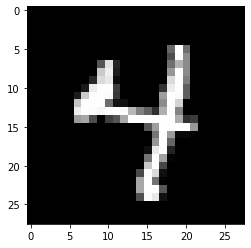

In [16]:
#test prediction with random image from testing set 

index = random.randint(0, 10000)

plt.imshow(testing_images[index], cmap = 'gray')
print('true label:', testing_labels[index])

prediction = np.matmul(A_matrix, testing_images_f[index])

print(prediction)
print('1st prediction:', np.argsort(prediction)[9])
print('2nd prediction:', np.argsort(prediction)[8])
print('3rd prediction:', np.argsort(prediction)[7])

index = random.randint(0, 10000)


In [17]:
#calculate training rmse 

predictions = np.matmul(A_matrix, np.transpose(training_images_f[:]))
predictions = np.transpose(predictions)

sum = np.sum((training_labels_oh - predictions)**2)

train_rmse = np.sqrt(sum/(10*60000))

print('training rmse loss:', train_rmse)

#calculate train accuracy 
accuracy = 0
for i in range(len(predictions)):
  correct = int(training_labels[i] == np.argmax(predictions[i]))
  if correct:
    accuracy += 1
print('training accuracy', accuracy/60000)

#calculate test rmse 

predictions = np.matmul(A_matrix, np.transpose(testing_images_f[:]))
predictions = np.transpose(predictions)

sum = np.sum((testing_labels_oh - predictions)**2)

test_rmse = np.sqrt(sum/(10*10000))

print('testing rmse loss:', test_rmse) 

#calculate test accuracy 
accuracy = 0
for i in range(len(predictions)):
  correct = int(testing_labels[i] == np.argmax(predictions[i]))
  if correct:
    accuracy += 1
print('testing accuracy', accuracy/10000)

training rmse loss: 0.1977381409859439
training accuracy 0.8519333333333333
testing rmse loss: 0.19879340019911393
testing accuracy 0.8534


## Logistic Regression (Sklearn)

In [18]:
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(max_iter=200, verbose = 1)
model.fit(training_images_f, training_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s finished


LogisticRegression(max_iter=200, verbose=1)

In [21]:
#Evaluate the model on training data
accuracy = model.score(training_images_f, training_labels)
print("Training accuracy:", accuracy)

#Evaluate the model on test data
accuracy = model.score(testing_images_f, testing_labels)
print("Test accuracy:", accuracy)

Training accuracy: 0.93855
Test accuracy: 0.9268


true label: 2
prediction: 2


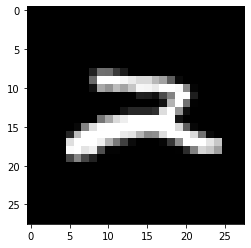

In [ ]:
#test prediction with random image from testing set 

index = random.randint(0, 10000)

plt.imshow(testing_images[index], cmap = 'gray')
print('true label:', testing_labels[index])

prediction = model.predict([testing_images_f[index]])[0]

#print(prediction)
print('prediction:', prediction)


## Deep Neural Network (Tensorflow API)

In [ ]:
from keras.utils import to_categorical
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import dtypes
import collections

tf.disable_v2_behavior()

tf.reset_default_graph() #reset graph 

#Define DataSet Class

X_train = np.array(training_images_f)
Y_train = to_categorical(training_labels)
X_test = np.array(testing_images_f)
Y_test = to_categorical(testing_labels)

class DataSet(object):

    def __init__(self,data_X,data_Y,dtype=dtypes.float32):
        """Checks data and casts it into correct data type. """
        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid dtype %r, expected uint8 or float32' % dtype)

        assert data_X.shape[0] == data_Y.shape[0], ('data_X.shape: %s data_Y.shape: %s' % (data_X.shape, data_Y.shape))
        self.num_examples = data_X.shape[0]

        if dtype == dtypes.float32:
            data_X = data_X.astype(np.float32)
        self.data_X = data_X
        self.data_Y = data_Y 

        self.epochs_completed = 0
        self.index_in_epoch = 0

    def next_batch(self, batch_size, seed=None):
        """Return the next `batch_size` examples from this data set."""
        if seed:
            np.random.seed(seed)
        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.num_examples:
            # Finished epoch
            self.epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.data_X = self.data_X[perm]
            self.data_Y = self.data_Y[perm]
            # Start next epoch
            start = 0
            self.index_in_epoch = batch_size
            assert batch_size <= self.num_examples
        end = self.index_in_epoch

        return self.data_X[start:end], self.data_Y[start:end]


n_feats = 28*28
n_categories = 10

n_hidden1 = 500
n_hidden2 = 400
n_hidden3 = 100
n_outputs = 10

#create Dataset Object
train = DataSet(X_train, Y_train, dtype=dtypes.float32)
test = DataSet(X_test, Y_test, dtype=dtypes.float32)

"""collections.namedtuple allows you to define tuple-like objects that have named fields. 
Named tuples are a convenient way to represent data with structured names, 
similar to a class, but using a tuple as the underlying storage. """

Datasets = collections.namedtuple('Datasets', ['train', 'test'])
Dataset = Datasets(train=train, test=test)

with tf.name_scope('data'):
  X = tf.placeholder(tf.float32, shape = (None, n_feats))
  Y = tf.placeholder(tf.float32, shape = (None, n_categories))

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#define neuron layer

def neuron_layer(X, n_neuron, name, activation = None):
  with tf.name_scope(name):
    n_inputs = int(X.get_shape()[1])
    stddev = 2 / np.sqrt(n_inputs + n_neuron)
    init = tf.truncated_normal((n_inputs, n_neuron), stddev = stddev) #initialize random weights 
    W = tf.Variable(init, name = 'kernel') # initialize weight matrix
    b = tf.Variable(tf.zeros([n_neuron]), name = 'bias') # initalize bias
    Z = tf.matmul(X, W) + b #define layer operation

    #activation function
    if activation is not None:
      return activation(Z)
    else:
      return Z

In [ ]:
#define nn architecture 

with tf.name_scope('dnn'):
  hidden1 = neuron_layer(X, n_hidden1, 'dense1', activation = tf.nn.relu)
  hidden2 = neuron_layer(hidden1, n_hidden2, 'dense2', activation = tf.nn.relu)
  hidden3 = neuron_layer(hidden2, n_hidden3, 'dense3', activation = tf.nn.relu)
  logits = neuron_layer(hidden2, n_outputs, 'dense4')

#define loss function

with tf.name_scope('loss'):
  xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = Y, logits = logits) # Measures the probability error in discrete classification tasks
  loss = tf.reduce_mean(xentropy) # Computes the mean of elements across dimensions of a tensor

#define optimizer
"""learning rate"""

learning_rate = 1e-2
with tf.name_scope('optimizer'):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

#define accuracy metric

with tf.name_scope('accuracy'):
  correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) #returns true if Y = logits and false otherwise
  correct_prediction = tf.cast(correct_prediction, tf.float64) #cast to tf datatype
  accuracy = tf.reduce_mean(correct_prediction)

In [ ]:
#progress bar

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

#EXAMPLE
'''out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))'''

'out = display(progress(0, 100), display_id=True)\nfor ii in range(101):\n    time.sleep(0.02)\n    out.update(progress(ii, 100))'

In [ ]:
#training

epochs = 10
batch_size= 128
training_steps = math.ceil(60000/batch_size) * epochs

''' A session is an object in TensorFlow that represents the environment in which a computation graph is executed. 
It is responsible for allocating resources (such as memory and compute resources) needed to execute the graph, 
and for performing the actual computations.'''

""" Dataset is a collections tuple"""

with tf.Session() as sess:

    # initialize the necessary variables, in this case, W and b
    sess.run(tf.global_variables_initializer())
    graph=tf.get_default_graph()
    # train the DNN
    out = display(progress(0,training_steps), display_id = True)
    
    for steps in range(training_steps): 
        
        out.update(progress(steps, training_steps))

        batch_X, batch_Y = Dataset.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={X: batch_X,Y: batch_Y})
        

    # test DNN performance on entire train test 
    train_loss, train_accuracy = sess.run([loss, accuracy], 
                                                feed_dict={X: Dataset.train.data_X, 
                                                           Y: Dataset.train.data_Y
                                                           }
                                                            )
    print("Training Loss:", train_loss)
    print("Training Accuracy:", train_accuracy)

    test_loss, test_accuracy = sess.run([loss, accuracy], 
                                                feed_dict={X: Dataset.test.data_X,
                                                           Y: Dataset.test.data_Y
                                                           }
                                                           )

    print("Testing Loss:", test_loss)
    print("Testing Accuracy:", test_accuracy)

    train_logits = sess.run([logits], feed_dict={X: Dataset.train.data_X, 
                                                           Y: Dataset.train.data_Y
                                                           })
    
    # Save the model
  
    saver = tf.train.Saver()
    saved_path = saver.save(sess, './my-model', global_step=1)

AttributeError: ignored

true label: 0
prediction: 0


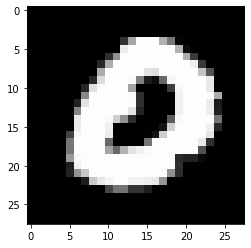

In [ ]:
#test prediction with random image from testing set 

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('/content/my-model-1.meta') #load the graph
    new_saver.restore(sess, tf.train.latest_checkpoint('./')) #restore variables
    index = random.randint(0, 10000)

    plt.imshow(testing_images[index], cmap = 'gray')
    print('true label:', testing_labels[index])

    prediction = sess.run([logits], feed_dict={X: testing_images_f[index].reshape(1,784)})

    #print(prediction)
    print('prediction:', np.argmax(prediction))


## Metropolis Hastings + Maximum Entropy 'image generation'

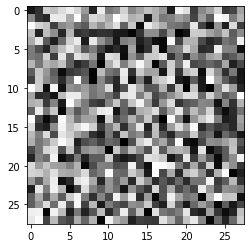

-5876661.758125942


<ipython-input-227-f3b91066431d>:61: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(new_likelihood - current_likelihood)


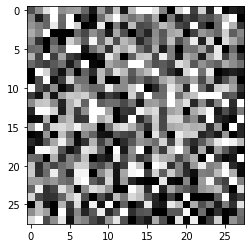

In [ ]:
def log_likelihood(target, prediction):
  return np.sum(-(target-prediction)**2/ (2*sigma**2) - len(target)*np.log(sigma) - 0.5*np.log(2*np.pi))

def sig(x, a):
 return 1/(1 + np.exp(-(x-a)))

#number to generate 

'''index = random.randint(0, 10000)
plt.imshow(testing_images[index], cmap = 'gray')
print('true label:', testing_labels[index])
number = testing_labels[index]   '''

number = 9
num_epochs = 10   # number of iterations over whole image
num_steps = num_epochs*784 
num_steps = 2000
target = convert_to_one_hot(number)
sigma = 0.01 # error hyperparameter
l = 0.1 # l hyperparameter
a = 0.3 # a hyperparameter
num_pix = 30

init_img = np.random.rand(784) #initalize random image
plt.imshow(init_img.reshape(28,28), cmap = 'gray')
plt.show()

img_gen = init_img

out = display(progress(0,num_steps), display_id = True) # progress bar

prediction = np.matmul(A_matrix, init_img)
print(log_likelihood(target, prediction))

for i in range(num_steps):
  out.update(progress(i, num_steps))

  # calculate current likelihood
  current_prediction = np.matmul(A_matrix, img_gen)

  current_likelihood = log_likelihood(target, current_prediction)

  # new img with random step
  new_img_gen = img_gen.copy()
  
  #new_img_gen[i%784] += l * np.random.normal(loc=0.0, scale=1.0, size=None)

  indices = np.random.randint(0, 784, size = num_pix)

  for i in indices:
    new_img_gen[i] += l * np.random.normal(loc=0.0, scale=1.0, size=None)
    new_img_gen[i] = max(0, new_img_gen[i]) #prevent negative pixels
    new_img_gen[i] = min(new_img_gen[i], 1) #prevent going over 1
  
  # calculate new likelihood
  new_prediction = np.matmul(A_matrix, new_img_gen)
  new_likelihood = log_likelihood(target, new_prediction)

  # decide whether to accept or reject new img 

  likelihood_ratio = np.exp(new_likelihood - current_likelihood)
  probability = min(likelihood_ratio, 1)
  decision = random.choices([1, 0], [probability, 1-probability])

  if (decision[0] == 1):
    img_gen = new_img_gen.copy()
  else:
    img_gen = img_gen
  
plt.imshow(img_gen.reshape(28,28), cmap = 'gray')
plt.show()


In [ ]:
prediction1 = np.matmul(A_matrix, init_img)
prediction2 = np.matmul(A_matrix, img_gen)
print('init log likelihood:', log_likelihood(target, prediction1))
print('final log likelihood:', log_likelihood(target, prediction2))
print('target', target)
print('final prediction', prediction2)
print('loss:', np.mean((target - prediction2)**2))

init log likelihood: -5876661.758125942
final log likelihood: 190.34530453955784
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
final prediction [0.0311009  0.10321293 0.0041523  0.06034508 0.10557553 0.05502261
 0.08430745 0.03969702 0.09528578 1.07057522]
loss: 0.00521964657454409


The Crude Least Squares Regression is a 'bad' mapping. 'Noisy' images can be confidently classified as a number. Try with sklearn logistic regression model and maximizing entropy. The main issue is that the inverse problem is highly underconstrained.

In [ ]:
from scipy.stats import entropy

m = model.coef_
b = model.intercept_

'''maximum entropy is the only method which does not introduce correlations in the
image, beyond those which are required by the data (Skilling et al. 1984)'''

def maximum_entropy(computed_img, target, l=1):

  prediction = softmax(np.matmul(m, computed_img) + b)

  chi2 = mean_squared_error(target, prediction, squared = True)

  S = entropy(computed_img)

  Q = S - l*chi2
  return -Q

#optimize 
index = random.randint(0, 10000)

number = training_labels[index]
target = convert_to_one_hot(number)

#init_img = np.ones(784)/10 #initalize blank image
init_img = training_images_f[index] #+ (np.random.normal(loc = 0.3, scale = 0.3, size = 784))
plt.imshow(init_img.reshape(28,28), cmap = 'gray')
plt.show()

target = softmax(np.matmul(m, training_images_f[index])+b)
result = minimize(maximum_entropy, x0 = init_img, args = (target))

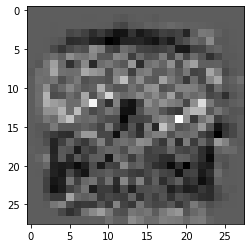

logits: [2.54804943e-154 0.00000000e+000 2.02426872e-002 1.91416526e-002
 1.57008886e-315 6.71465572e-003 2.32382540e-113 9.53901005e-001
 1.69034581e-016 7.11858748e-132]


In [ ]:
img_gen = result.x.reshape(28,28)
plt.imshow(img_gen, cmap = 'gray')
plt.show()

print('logits:', softmax(np.matmul(m, result.x) + b))

##Convolutional Neural Network (Keras)

In [ ]:
! pip install tensorflow

In [ ]:
import datetime, os

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import (Conv2D, MaxPooling2D, Activation, BatchNormalization)

from keras.callbacks import CSVLogger

In [ ]:
input_shape = (28, 28, 1)

X_train = training_images.reshape(training_images.shape[0], 28, 28, 1) / 255
Y_train = training_labels_oh
X_test = testing_images.reshape(testing_images.shape[0], 28, 28, 1) / 255
Y_test = testing_labels_oh

# build model 
model_CNN = Sequential()

model_CNN.add(Conv2D(32, (3,3), input_shape = input_shape))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(rate=0.1))

model_CNN.add(Conv2D(64, (3,3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(rate=0.1))

model_CNN.add(Flatten())

model_CNN.add(Dense(32, activation = 'relu'))
model_CNN.add(Dropout(rate = 0.1))

model_CNN.add(Dense(10, activation = 'softmax'))

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        1

In [ ]:
epochs = 5
batch_size = 128

# reduce learning rate callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=1e-13, verbose=1, cooldown=0)

# csv logger callback
csv_logger = CSVLogger('/content/cnn_log.csv', append=False, separator=';')

# save model over epochs
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
model_path = f'/content/nn_results/cnn_{run_time_string}.h5'
model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_loss', 
        save_best_only=True, 
        mode='min',
        verbose=1)

# set learning rate / compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_CNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

In [ ]:
#fit model
model_CNN.fit(X_train, Y_train, epochs = epochs, 
              batch_size = batch_size, validation_data = (X_test, Y_test),
              callbacks = [csv_logger, reduce_lr, model_check])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 0s - loss: 0.2546 - acc: 0.9199

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.09240, saving model to /content/nn_results/cnn_2023-01-01T00:10.h5
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.2546 - acc: 0.9199 - val_loss: 0.0924 - val_acc: 0.9828 - lr: 0.0010
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.0866 - acc: 0.9738
Epoch 2: val_loss improved from 0.09240 to 0.04440, saving model to /content/nn_results/cnn_2023-01-01T00:10.h5
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.0866 - acc: 0.9738 - val_loss: 0.0444 - val_acc: 0.9870 - lr: 0.0010
Epoch 3/5
60000/60000 [==============================] - ETA: 0s - loss: 0.0655 - acc: 0.9798
Epoch 3: val_loss improved from 0.04440 to 0.03996, saving model to /content/nn_results/cnn_2023-01-01T00:10.h5
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.0655 - acc: 0.9798 - val_loss: 0.0400 - val_acc: 0.9865 - lr: 0.0010
Epoch 4/5
60000/60000 [==============================] 

In [ ]:
# view logs

df = pd.read_csv('/content/cnn_log.csv', sep = ';')
losses = df['loss']
val_losses = df['val_loss']
epochs = np.linspace(0, len(df['epoch']), len(df['epoch']))
print(df)

plt.figure(figsize = (7,3))
plt.plot(epochs, val_losses, label = 'validation loss')
plt.plot(epochs, losses, label = 'training loss')
plt.title('Loss vs epoch', size = 20)
plt.xlabel("Epoch", size = 15)
plt.ylabel("MSE Loss", size = 15)
plt.grid()
plt.legend()

FileNotFoundError: ignored

true label: 2
prediction: 2
logits: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


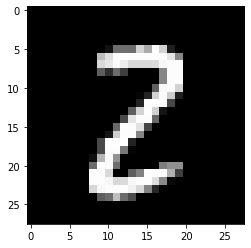

In [ ]:
# test prediction with random image from testing set 

index = random.randint(0, 10000)

plt.imshow(testing_images[index], cmap = 'gray')
print('true label:', testing_labels[index])

test_img = testing_images[index].reshape(1, 28, 28, 1)

prediction = model_CNN.predict([test_img])

#print(prediction)
print('prediction:', np.argmax(prediction))
print('logits:', prediction)

## Logistic Regression (Keras)

In [ ]:
input_shape = np.shape(training_images_f[0])

X_train = training_images.reshape(training_images.shape[0], 784) / 255
Y_train = training_labels_oh
X_test = testing_images.reshape(testing_images.shape[0], 784) / 255
Y_test = testing_labels_oh

# define architecture
x = keras.Input(shape=input_shape)
y = Dense(10, activation='softmax')(x)
model = keras.Model(x, y)

epochs = 10
batch_size = 128

# set learning rate / compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

# fit
model.fit(X_train, Y_train, epochs = epochs, 
              batch_size = batch_size, validation_data = (X_test, Y_test)) 

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.6782 - accuracy: 0.8336 - val_loss: 0.3837 - val_accuracy: 0.9017
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3610 - accuracy: 0.9028 - val_loss: 0.3176 - val_accuracy: 0.9142
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.9122 - val_loss: 0.2981 - val_accuracy: 0.9190
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2992 - accuracy: 0.9167 - val_loss: 0.2860 - val_accuracy: 0.9214
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2876 - accuracy: 0.9198 - val_loss: 0.2799 - val_accuracy: 0.9224
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2797 - accuracy: 0.9223 - val_loss: 0.2755 - val_accuracy: 0.9234
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.2737 - accuracy: 0.9237 - val_loss: 0.2703 - val_accuracy: 0.9257
Epoch 

## Simple Autoencoder (Keras)

https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
input_shape = np.shape(training_images_f[0])

X_train = training_images.reshape(training_images.shape[0], 784) / 255
Y_train = training_labels_oh
X_test = testing_images.reshape(testing_images.shape[0], 784) / 255
Y_test = testing_labels_oh

encoding_dim = 12

# input image -> reconstructed image 
input = keras.Input(shape = input_shape)
encoded = Dense(encoding_dim, activation = 'relu')(input)
decoded = Dense(input_shape[0], activation = 'sigmoid')(encoded)  #sigmoid to keep pixels from 0 to 1
autoencoder = keras.Model(input, decoded)

# separate encoder model taken from autoencoder model
encoder = keras.Model(input, encoded)

# separate decoder model from autoencoder model
encoded_input = keras.Input(shape = (encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# set learning rate / compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_50 (Dense)            (None, 12)                9420      
                                                                 
 dense_51 (Dense)            (None, 784)               10192     
                                                                 
Total params: 19,612
Trainable params: 19,612
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10
batch_size = 128

#fit autoencoder compare input X_train with output X_train 
autoencoder.fit(X_train, X_train, epochs = epochs, batch_size = batch_size, shuffle = True,
                validation_data = (X_test, X_test))

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2690 - accuracy: 0.0146 - val_loss: 0.1982 - val_accuracy: 0.0146
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1815 - accuracy: 0.0111 - val_loss: 0.1678 - val_accuracy: 0.0120
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1635 - accuracy: 0.0111 - val_loss: 0.1584 - val_accuracy: 0.0141
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1577 - accuracy: 0.0130 - val_loss: 0.1547 - val_accuracy: 0.0134
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1547 - accuracy: 0.0133 - val_loss: 0.1521 - val_accuracy: 0.0109
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1526 - accuracy: 0.0127 - val_loss: 0.1503 - val_accuracy: 0.0112
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1508 - accuracy: 0.0116 - val_loss: 0.1486 - val_accuracy: 0.0094
Epoch 

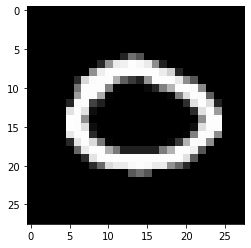

true label: 0
1/1 [==============================] - 0s 12ms/step


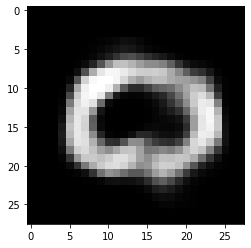

encoded_img: [[ 0.16372788 10.255023    6.374747    6.698881    1.355401    7.4627447
  12.420594    0.19984579 13.578045   15.966663    1.8056484  14.648109  ]]


In [ ]:
# test reconstruction 

index = random.randint(0, 10000)

plt.imshow(testing_images[index], cmap = 'gray')
plt.show()
print('true label:', testing_labels[index])
test_img = X_test[index].reshape(1, 784)

encoded_img = encoder.predict(test_img)
decoded_img = decoder.predict(encoded_img)

plt.imshow(decoded_img.reshape(28,28), cmap = 'gray')
plt.show()

print('encoded_img:', encoded_img)

## Convolutional Autoencoder (Keras)

In [ ]:
input_shape = (28, 28, 1)

X_train = training_images.reshape(training_images.shape[0], 28, 28, 1) / 255
Y_train = training_labels_oh
X_test = testing_images.reshape(testing_images.shape[0], 28, 28, 1) / 255
Y_test = testing_labels_oh

# create noisy training data
def add_noise(images):
  
  noise_factor = 0.3
  noisy_images = images + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=images.shape)
    
  return np.clip(noisy_images, 0.0, 1.0)


X_train_noisy = add_noise(X_train)
X_test_noisy = add_noise(X_test)

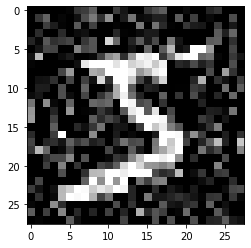

In [ ]:
# plot noisy image

plt.imshow(X_train_noisy[0].reshape(28,28), cmap = 'gray')

In [ ]:
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D

# autoencoder architecture

# encoder 
input = keras.Input(shape = input_shape)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(input)
pool_1 = MaxPooling2D((2,2), padding = 'same')(conv_1)
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(pool_1)
encoded = MaxPooling2D((2,2), padding = 'same')(conv_2)

# decoder
deconv_1 = Conv2DTranspose(32, (3,3), activation = 'relu', padding = 'same')(encoded)
upsample_1 = UpSampling2D((2,2))(deconv_1)
deconv_2 = Conv2DTranspose(64, (3,3), activation = 'relu', padding = 'same')(upsample_1)
upsample_2 = UpSampling2D((2,2))(deconv_2)
decoded = Conv2DTranspose(1, (3,3), activation = 'relu', padding = 'same')(upsample_2)

autoencoder_C = keras.Model(input, decoded)

# set learning rate / compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder_C.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])

autoencoder_C.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 7, 7, 32)         924

In [ ]:
epochs = 6
batch_size = 128

#fit autoencoder compare input X_train with output X_train 
autoencoder_C.fit(X_train, X_train, epochs = epochs, batch_size = batch_size, shuffle = True,
                validation_data = (X_test, X_test))

Epoch 1/6
469/469 [==============================] - 149s 316ms/step - loss: 0.1373 - accuracy: 0.8101 - val_loss: 0.0977 - val_accuracy: 0.8129
Epoch 2/6
469/469 [==============================] - 155s 331ms/step - loss: 0.1007 - accuracy: 0.8137 - val_loss: 0.0910 - val_accuracy: 0.8138
Epoch 3/6
469/469 [==============================] - 155s 331ms/step - loss: 0.1133 - accuracy: 0.8123 - val_loss: 0.0972 - val_accuracy: 0.8130
Epoch 4/6
469/469 [==============================] - 152s 325ms/step - loss: 0.0966 - accuracy: 0.8141 - val_loss: 0.0910 - val_accuracy: 0.8129
Epoch 5/6
469/469 [==============================] - 149s 319ms/step - loss: 0.0981 - accuracy: 0.8136 - val_loss: 0.0961 - val_accuracy: 0.8135
Epoch 6/6
469/469 [==============================] - 151s 321ms/step - loss: 0.1124 - accuracy: 0.8131 - val_loss: 0.1001 - val_accuracy: 0.8126


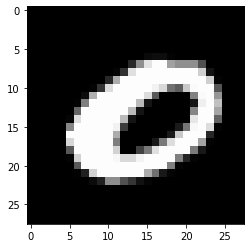

true label: 0
1/1 [==============================] - 0s 20ms/step


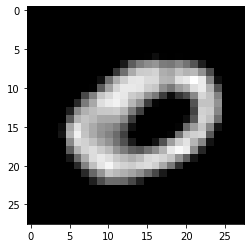

In [ ]:
# test reconstruction 

index = random.randint(0, 10000)

plt.imshow(testing_images[index], cmap = 'gray')
plt.show()
print('true label:', testing_labels[index])
test_img = X_test[index].reshape(1,28,28,1)

decoded_img = autoencoder_C.predict(test_img)

plt.imshow(decoded_img.reshape(28,28), cmap = 'gray')
plt.show()


In [ ]:
# train autoencoder with noisy images 

epochs = 6
batch_size = 128

autoencoder_C.fit(X_train_noisy, X_train, epochs = epochs, batch_size = batch_size, shuffle = True,
                validation_data = (X_test_noisy, X_test))

Epoch 1/6
469/469 [==============================] - 147s 314ms/step - loss: 0.1226 - accuracy: 0.8121 - val_loss: 0.1077 - val_accuracy: 0.8128
Epoch 2/6
469/469 [==============================] - 149s 318ms/step - loss: 0.1141 - accuracy: 0.8129 - val_loss: 0.1025 - val_accuracy: 0.8131
Epoch 3/6
469/469 [==============================] - 152s 324ms/step - loss: 0.1060 - accuracy: 0.8137 - val_loss: 0.1020 - val_accuracy: 0.8130
Epoch 4/6
469/469 [==============================] - 149s 317ms/step - loss: 0.1233 - accuracy: 0.8124 - val_loss: 0.1461 - val_accuracy: 0.8037
Epoch 5/6
469/469 [==============================] - 147s 314ms/step - loss: 0.1304 - accuracy: 0.8105 - val_loss: 0.1147 - val_accuracy: 0.8115
Epoch 6/6
469/469 [==============================] - 146s 311ms/step - loss: 0.1121 - accuracy: 0.8128 - val_loss: 0.1049 - val_accuracy: 0.8125


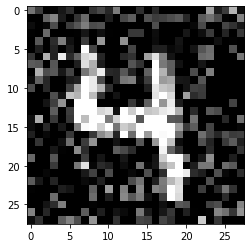

true label: 4


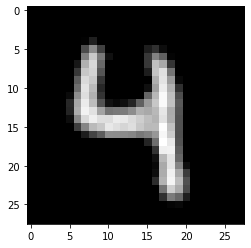

In [ ]:
# test reconstruction 

index = random.randint(0, 10000)

plt.imshow(X_test_noisy[index].reshape(28,28), cmap = 'gray')
plt.show()
print('true label:', testing_labels[index])
test_img = X_test[index].reshape(1,28,28,1)

decoded_img = autoencoder_C.predict(test_img, verbose = False)

plt.imshow(decoded_img.reshape(28,28), cmap = 'gray')
plt.show()

## Convolutional VAE (Keras)

In [ ]:
import datetime, os

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import (Conv2D, MaxPooling2D, Activation, BatchNormalization)

from keras.callbacks import CSVLogger
from keras import backend as K
from keras.layers import Lambda
from keras.layers.core import Reshape
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D


In [ ]:
#reshaped and normalized

input_shape = (28, 28, 1)
X_train = training_images.reshape(training_images.shape[0], 28, 28, 1) / 255
Y_train = training_labels
X_test = testing_images.reshape(testing_images.shape[0], 28, 28, 1) / 255
Y_test = testing_labels

latent_dim = 2

# sampler

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon


# encoder map to latent variables

inputs = keras.Input(shape = input_shape)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(inputs)
pool_1 = MaxPooling2D((2,2), padding = 'same')(conv_1)
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(pool_1)
pool_2 = MaxPooling2D((2,2), padding = 'same')(conv_2)
flatten_1 = Flatten()(pool_2)
fc_1 = Dense(64, activation = 'relu')(flatten_1)       
z_mean = Dense(latent_dim)(fc_1)
z_log_sigma = Dense(latent_dim)(fc_1)    

z = Lambda(sampling)([z_mean, z_log_sigma]) # layer that takes z_mean and z_log_sigma as inputs and outputs vector z

encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name = 'encoder')

# decoder

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling') # latent dim = dim of z
fc_2 = Dense(64, activation = 'relu')(latent_inputs)
fc_3 = Dense(7*7*32, activation = 'relu')(fc_2)
reshape_1 = Reshape((7,7,32))(fc_3)
deconv_1 = Conv2DTranspose(32, (3,3),  activation = 'relu', padding = 'same')(reshape_1)
upsample_1 = UpSampling2D((2,2))(deconv_1)
deconv_2 = Conv2DTranspose(64, (3,3), activation = 'relu', padding = 'same')(upsample_1)
upsample_2 = UpSampling2D((2,2))(deconv_2)
decoded = Conv2DTranspose(1, (3,3), activation = 'sigmoid', padding = 'same')(upsample_2)

decoder = keras.Model(latent_inputs, decoded, name = 'decoder')

# create VAE (piece encoder and decoder together)

outputs = decoder(encoder(inputs)[2]) # extracting z vector from encoder output 
vae = keras.Model(inputs, outputs, name='vae_mlp')

encoder.summary()
decoder.summary()
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 28, 28, 64)   640         ['input_10[0][0]']               
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 14, 14, 64)  0           ['conv2d_18[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 14, 14, 32)   18464       ['max_pooling2d_18[0][0]'] 

In [ ]:
# create custom loss function and compile

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs, axis = (1,2,3)) * 784
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)) 
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)
  

In [ ]:
# fit 
epochs = 50
batch_size = 32

vae.fit(X_train, X_train, epochs = epochs, batch_size = batch_size, validation_data = [X_test, X_test])

Epoch 1/50
1875/1875 [==============================] - 12s 6ms/step - loss: 163.9939 - val_loss: 150.1915
Epoch 2/50
1875/1875 [==============================] - 11s 6ms/step - loss: 148.6748 - val_loss: 147.1564
Epoch 3/50
1875/1875 [==============================] - 12s 6ms/step - loss: 145.5583 - val_loss: 143.9820
Epoch 4/50
1875/1875 [==============================] - 11s 6ms/step - loss: 143.4939 - val_loss: 142.7874
Epoch 5/50
1875/1875 [==============================] - 11s 6ms/step - loss: 142.1603 - val_loss: 142.2100
Epoch 6/50
1875/1875 [==============================] - 12s 7ms/step - loss: 141.0625 - val_loss: 140.9966
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 140.2387 - val_loss: 140.6397
Epoch 8/50
1875/1875 [==============================] - 11s 6ms/step - loss: 139.5484 - val_loss: 140.3728
Epoch 9/50
1875/1875 [==============================] - 11s 6ms/step - loss: 138.9605 - val_loss: 139.5380
Epoch 10/50
1875/1875 [==============

313/313 [==============================] - 1s 2ms/step


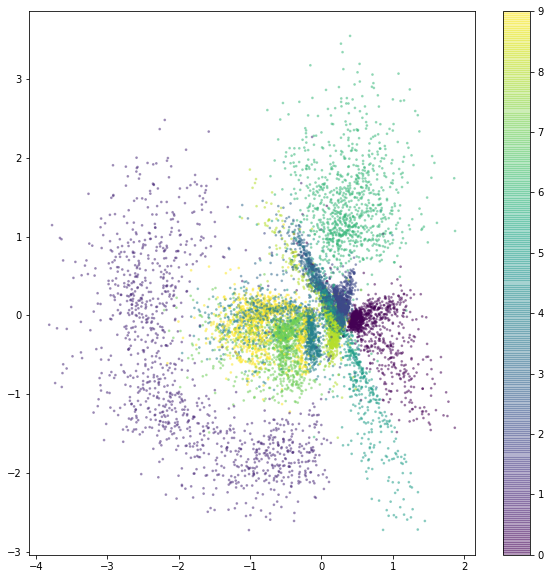

In [ ]:
# plot latent distributions

x_test_encoded = encoder.predict(X_test, batch_size=32)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=testing_labels, s = 3, alpha = 0.4)
plt.colorbar()
plt.show()

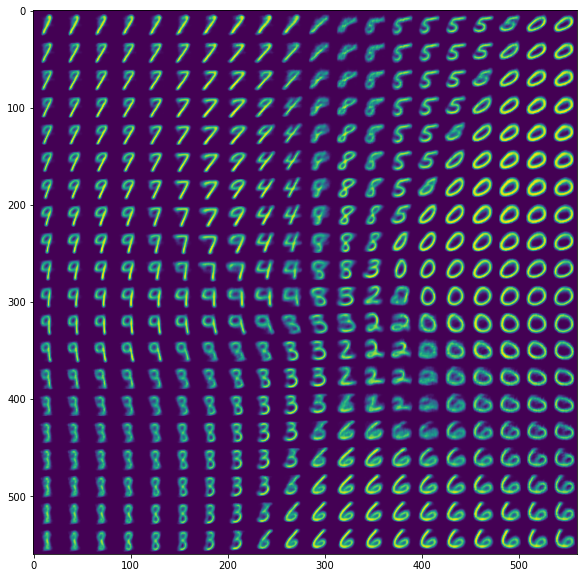

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1.1, 1.1, n)
grid_y = np.linspace(-1.1, 1.1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose = False)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

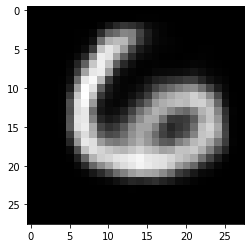

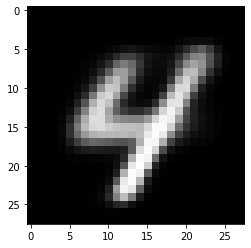

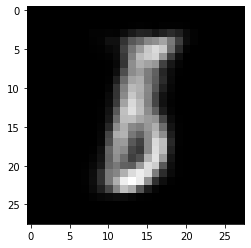

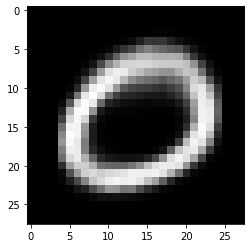

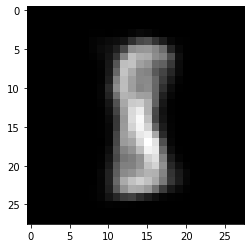

In [ ]:
# generate random numbers 

scale = 1.0

for i in range(5):
  x = np.random.normal(loc = 0.0, scale = scale)
  y = np.random.normal(loc = 0.0, scale = scale)
  z_vector_sampled = np.array([[x,y]])
  decoded = decoder.predict(z_vector_sampled, verbose = False)
  image = decoded[0].reshape(28,28)

  plt.imshow(image, cmap = 'gray')
  plt.show()


## CVAE with Anime Faces

Datasets: 

https://www.kaggle.com/datasets/splcher/animefacedataset

https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset

https://www.kaggle.com/datasets/soumikrakshit/anime-faces


In [1]:
import datetime, os
from os import listdir
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import (Conv2D, MaxPooling2D, Activation, BatchNormalization)

from keras.callbacks import CSVLogger
from keras import backend as K
from keras.layers import Lambda
from keras.layers.core import Reshape
from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D
from keras.layers import LeakyReLU

import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.image as mpimg
import random
import math

import cv2 

In [13]:
# extract anime images >.<

'''import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/ML Projects/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML Projects/anime_images')'''

"import zipfile\n\nwith zipfile.ZipFile('/content/drive/MyDrive/ML Projects/archive.zip', 'r') as zip_ref:\n    zip_ref.extractall('/content/drive/MyDrive/ML Projects/anime_images')"

In [2]:
# load file names
anime_image_files = os.listdir('/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_1') 
print('file name:', anime_image_files[0])
print('number of images:', len(anime_image_files))

file name: 99116786_result.jpg
number of images: 58011


image shape: (256, 256, 3)


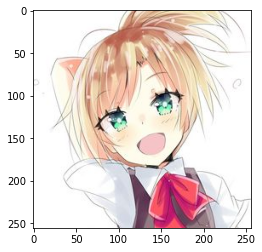

In [4]:
# load image 

file_name = random.choice(anime_image_files)

def load_image(file_name):
  file_path = '/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_1/' + str(file_name)
  image = np.array(cv2.imread(file_path))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image / 255.0

image = load_image(file_name)
print('image shape:', np.shape(image))
plt.imshow(load_image(file_name))
plt.show()

In [10]:
img_height = 64 # make sure sizes are even
img_width = 64

data_dir_2 = '/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_2'

dataset_2 = keras.utils.image_dataset_from_directory(
    data_dir_2, label_mode=None, image_size=(img_height, img_width),
    shuffle = True, seed = None, batch_size = 128 
)

dataset_2 = dataset_2.map(lambda x: x / 255.0)

data_dir_3 = '/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_3'

dataset_3 = keras.utils.image_dataset_from_directory(
    data_dir_3, label_mode=None, image_size=(img_height, img_width),
    shuffle = True, seed = None, batch_size = 128
)

dataset_3 = dataset_3.map(lambda x: x / 255.0)

data_dir_1 = '/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_1'

dataset_1 = keras.utils.image_dataset_from_directory(
    data_dir_1, label_mode=None, image_size=(img_height, img_width),
    shuffle = True, seed = None, batch_size = 128
)

dataset_1 = dataset_1.map(lambda x: x / 255.0)

data_dir_4 = '/Users/andrewgoh/Desktop/ML_Projects/misc/anime_images_4'

dataset_4 = keras.utils.image_dataset_from_directory(
    data_dir_4, label_mode=None, image_size=(img_height, img_width),
    shuffle = True, seed = None, batch_size = 128
)

dataset_4 = dataset_4.map(lambda x: x / 255.0)

Found 37494 files belonging to 1 classes.
Found 40924 files belonging to 1 classes.
Found 58011 files belonging to 1 classes.
Found 40906 files belonging to 1 classes.


In [11]:
# concatenate datasets

dataset = dataset_1.concatenate(dataset_2)
dataset = dataset.concatenate(dataset_3)
dataset = dataset.concatenate(dataset_4)

#dataset = dataset.repeat()


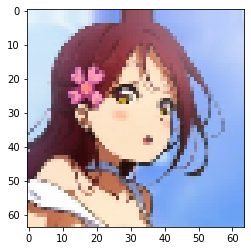

In [12]:
# test dataset 

subset = dataset.take(1)

for i in subset:
    img = i.numpy()
    plt.imshow(img[0].reshape(64,64,3))

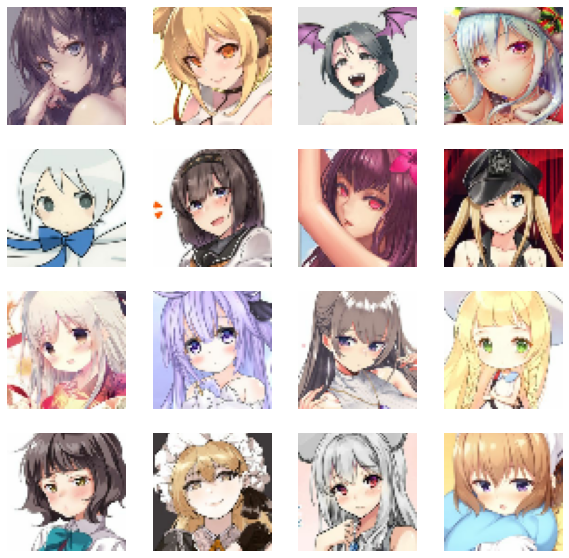

In [13]:
# plot images
plt.figure(figsize=(10, 10))
for images in dataset:
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((images[i].numpy() * 255).astype("int32"))
    plt.axis("off")
  
  break

In [18]:
# build encoder and decoder

input_shape = (img_height,img_width,3)
latent_dim = 900
dense_dim = 1300

# sampler

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(0.5*z_log_var) * epsilon


# encoder map to latent variables

inputs = keras.Input(shape = input_shape)
init_conv = Conv2D(32, (3,3), padding = 'same')(inputs)
init_batch = BatchNormalization()(init_conv)
init_act = LeakyReLU()(init_batch)

x = Conv2D(32, (3,3), padding = 'same')(init_act)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(64, (3,3), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_1 = Conv2D(64, (3,3), padding = 'same')(x)
batch_1 = BatchNormalization()(conv_1)
activation_1 = LeakyReLU()(batch_1)

conv_2 = Conv2D(128, (3,3), strides = 2, padding = 'same')(activation_1)
batch_2 = BatchNormalization()(conv_2)
activation_2 = LeakyReLU()(batch_2)

conv_3 = Conv2D(256, (5,5), strides = 2, padding = 'same')(activation_2)
batch_3 = BatchNormalization()(conv_3)
activation_3 = LeakyReLU()(batch_3)

conv_4 = Conv2D(350, (5,5), strides = 2, padding = 'same')(activation_3)
batch_4 = BatchNormalization()(conv_4)
activation_4 = LeakyReLU()(batch_4)

shape_before_flatten = K.int_shape(activation_4)[1:]
flatten_1 = Flatten()(activation_4)

fc_1 = Dense(dense_dim, activation = 'relu')(flatten_1) 
b_1 = BatchNormalization()(fc_1)
r_1 = LeakyReLU()(b_1)

z_mean = Dense(latent_dim)(r_1)
z_log_var = Dense(latent_dim)(r_1)    

z = Lambda(sampling)([z_mean, z_log_var]) # layer that takes z_mean and z_log_sigma as inputs and outputs vector z

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name = 'encoder')

# decoder

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling') # latent dim = dim of z
fc_2 = Dense(dense_dim, activation = 'relu')(latent_inputs)
b_2 = BatchNormalization()(fc_2)
r_2 = LeakyReLU()(b_2)

fc_3 = Dense(np.prod(shape_before_flatten), activation = 'relu')(r_2)
reshape_1 = Reshape(shape_before_flatten)(fc_3)

deconv_1 = Conv2DTranspose(350, (5,5), strides = 2, padding = 'same')(reshape_1)
batch_5 = BatchNormalization()(deconv_1)
activation_6 = LeakyReLU()(batch_5)

deconv_2 = Conv2DTranspose(256, (5,5),  strides = 2, padding = 'same')(activation_6)
batch_5 = BatchNormalization()(deconv_2)
activation_7 = LeakyReLU()(batch_5)

deconv_3 = Conv2DTranspose(128, (5,5),  strides = 2, padding = 'same')(activation_7)
batch_6 = BatchNormalization()(deconv_3)
activation_8 = LeakyReLU()(batch_6)

deconv_4 = Conv2DTranspose(64, (3,3), padding = 'same')(activation_8)
batch_7 = BatchNormalization()(deconv_4)
activation_9 = LeakyReLU()(batch_7)

y = Conv2DTranspose(64, (3,3), padding = 'same')(activation_9)
y = BatchNormalization()(y)
y = LeakyReLU()(y)

y = Conv2DTranspose(32, (3,3), padding = 'same')(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)

final_deconv = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same')(y)
decoded = LeakyReLU()(final_deconv)

decoder = keras.Model(latent_inputs, decoded, name = 'decoder')

encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 64, 64, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_30 (BatchN  (None, 64, 64, 32)  128         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_32 (LeakyReLU)     (None, 64, 64, 32)   0           ['batch_normalization_30[0]

In [19]:
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta = 0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
          
    
    @property 
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    # training logic for CVAE 
    def train_step(self, data):
        with tf.GradientTape() as tape:
          # encode batch to latent variables
          z_mean, z_log_var, z = self.encoder(data) 
          # decode batch from z 
          reconstruction = self.decoder(z) 
          """calculate L2 loss across pixels and channels of each image in batch, then calculate mean of batch """
          #reconstruction_loss = K.mean(K.square(data - reconstruction))
          """calculate log cosh loss """
          reconstruction_loss = tf.keras.losses.logcosh(data, reconstruction)
          # calculate kl loss across latent variables of each image in batch
          kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
          # sum loss over latent dimensions, calculate mean of batch
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
          # calculate total loss, include B regularizzer
          total_loss = reconstruction_loss + self.beta * kl_loss

        # grad loss wrt weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # apply gradients to weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # update state of trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [16]:
# reduce learning rate callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.6,
                              patience=4, min_lr=1e-13, verbose=1, cooldown=0)

# csv logger callback
csv_logger = CSVLogger('/Users/andrewgoh/Desktop/ML_Projects/misc/cvae_log_overnight.csv', append=True, separator=';')

# save model over epochs
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
model_path = f'/Users/andrewgoh/Desktop/ML_Projects/misc/cvae_results/cvae_{run_time_string}.h5'
model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='loss', 
        save_best_only=True, 
        mode='min',
        verbose=1)

In [21]:
#FIT

# define annealing schedule

""""
too small beta: bigger kl loss, improve reconstruction, cursed, longer training?
too big beta: vanishing kl loss, less meaningful generations,  
"""

"""
def make_beta_list(epochs, max_value, min_value = 0, cyclic = True):
    beta_list = []
    sequence = [min_value, max_value*0.5, max_value, max_value]

    if(cyclic == True):
        for i in range(epochs):
            a = (i+1)%4
            beta_list.append(sequence[a-1])
        
        return beta_list
    else:
        beta_list = [min_value, max_value*0.1, max_value*0.5, max_value]
        for i in range(epochs-4):
            beta_list.append(max_value)
        
        return beta_list
"""

'''
# set beta values
max_value = 0.029
min_value = 0.0004
beta_list = make_beta_list(epochs = epochs, max_value = max_value,
                       min_value = min_value, cyclic = False
'''
    

# set epoch/steps/beta

epochs = 1
#steps_per_epoch = 100

beta = 0.00005
print('beta:', beta)

cvae = CVAE(encoder, decoder, beta = beta)
cvae.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0004))

cvae.fit(dataset, epochs = 1, 
            #steps_per_epoch = steps_per_epoch, 
            shuffle = True,
            callbacks = [csv_logger])

beta: 1e-05
1387/1387 [==============================] - 18479s 13s/step - loss: 0.0189 - reconstruction_loss: 0.0136 - kl_loss: 20.2228


In [873]:
"""save weights"""
#cvae.save_weights('/Users/andrewgoh/Desktop/ML_Projects/misc/cvae_weights_64', overwrite=True, save_format=None, options=None)

In [39]:
"""load weights"""
#cvae = CVAE(encoder, decoder)
#cvae.load_weights('/Users/andrewgoh/Desktop/ML_Projects/misc/cvae_weights_best', by_name=False, skip_mismatch=False, options=None)

# set optimizer and compile 
#optimizer = keras.optimizers.Adam(learning_rate=0.001)
#cvae.compile(optimizer=optimizer)

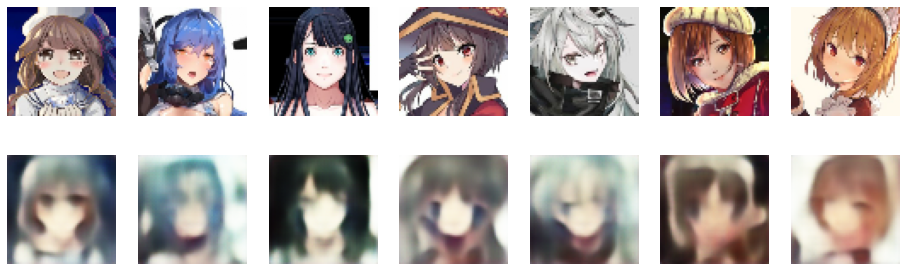

In [23]:
# test reconstruction

plt.figure(figsize = (16,5))
for i in range(7):
    ax = plt.subplot(2, 7, i + 1)
    image = dataset.take(count = 1)
    img = list(image.as_numpy_iterator())
    plt.imshow(img[0][0])
    plt.axis('off')

    ax = plt.subplot(2,7, i+8)
    zm, zv, zs = encoder.predict(img, verbose = False)
    decoded = decoder.predict(zs, verbose = False)
    reconstructed_image = decoded[0].reshape(img_height, img_width, 3)
    plt.imshow(reconstructed_image)
    plt.axis('off')



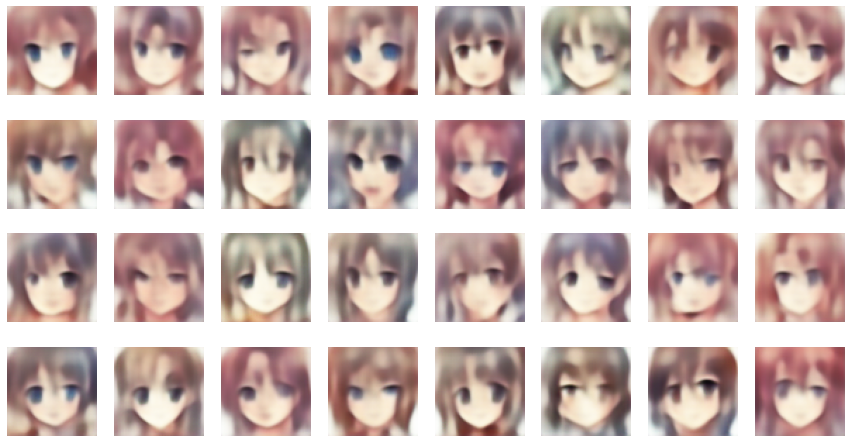

In [28]:
# generate random anime faces

scale = 0.5
length = 0.5

plt.figure(figsize=(15,8))
for i in range(32):
  z = []
  for j in range(latent_dim):
    z.append(np.random.normal(loc = np.random.uniform(-length, length), scale = scale))

  ax = plt.subplot(4, 8, i + 1)
  z_vector_sampled = np.array([z])
  decoded = decoder.predict(z_vector_sampled, verbose = False)
  image = decoded[0].reshape(img_height,img_width, 3)
  plt.imshow(image)
  plt.axis("off")

In [788]:
import imageio

# animate traversal through latent space

step_size = 0.08
steps = 50

# sample random z
z = []
for j in range(latent_dim):
    z.append(np.random.normal(loc = np.random.uniform(-length, length), scale = scale))

#init image
z_vector_sampled = np.array(list(zs))
decoded = decoder.predict(z_vector_sampled, verbose = False)
image = decoded[0].reshape(img_height,img_width, 3)

for i in range(steps):
    z_vector_sampled += list(np.random.uniform(-step_size, step_size, size = latent_dim))
    decoded = decoder.predict(z_vector_sampled, verbose = False)
    image = decoded[0].reshape(img_height,img_width, 3)
    plt.imshow(image)
    plt.axis("off")
    plt.savefig(f'/Users/andrewgoh/Desktop/ML_Projects/animations/face-{i}.png')
    plt.close()

# animate
with imageio.get_writer('faces.gif', mode='i', duration = 0.001) as writer:
    for i in range(steps):
        image = imageio.imread(f'animations/face-{i}.png')
        writer.append_data(image)